In [1]:
# Import Libraries and Dependencies
import constrained_optimization
from constrained_optimization.base import*
from constrained_optimization.generate import*

In [2]:
dimX = 10
dimY = 10
dimU = 10
p, q, r, A, b = randQCQP(dimX,dimY,True,True, dimU)
fx, hx, gradf, gradh = toQCQP(p, q, r)

In [3]:
hxs = []
gradhs = []
for i in range(len(hx)):
    temp = lambda x: -1*hx[i](x)
    hxs.append(temp)
    temp = lambda x: -1*gradh[i](x)
    gradhs.append(temp)

prob = co_problem(fx, dimX, hxs, None, gradf, gradhs, A, b)

x = np.ones(10)
F_co, J_co = prob.get_parameters(False)

## Adaptive Graal to solve VI

In [4]:
def adaptive_graal(J, F, prox_g, x1, numb_iter=100, phi=1.5, output=False): 
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    for i in range(numb_iter):
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = n1/n2 if n2 != 0 else la*10

        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)
        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)
    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, x_, time_list
def adaptive_graal_terminate(J, F, prox_g, x1, numb_iter=100, phi=1.5, tol=1e-6, output=False):
    begin = perf_counter()
    x, x_ = x1.copy(), x1.copy()
    x0 = x + np.random.randn(x.shape[0]) * 1e-9
    Fx = F(x)
    la = phi / 2 * LA.norm(x - x0) / LA.norm(Fx - F(x0))
    rho = 1. / phi + 1. / phi**2
    values = [J(x)]
    time_list = [perf_counter() - begin]
    th = 1

    i = 1
    while i <= numb_iter and values[-1] > tol:
        i += 1
        x1 = prox_g(x_ - la * Fx, la)
        Fx1 = F(x1)

        n1 = LA.norm(x1 - x)**2
        n2 = LA.norm(Fx1 - Fx)**2
        n1_div_n2 = np.exp(np.log(n1) - np.log(n2))
        la1 = min(rho * la, 0.25 * phi * th / la * n1_div_n2, 1e6)
        x_ = ((phi - 1) * x1 + x_) / phi
        if output:
            print (i, la)

        th = phi * la1 / la
        x, la, Fx = x1, la1, Fx1
        values.append(J(x))
        time_list.append(perf_counter() - begin)

    end = perf_counter()

    print("CPU time for aGRAAL:", end - begin)
    return values, x, i


## Solver of VI

In [5]:
prox_g = lambda q, eps: np.fmax(q,0)
# starting point
N = 1000
q0 = np.ones(dimX + dimY + dimU)
print(F_co(q0).shape)

(30,)


In [6]:
ans1 = adaptive_graal(J_co, F_co, prox_g, q0, numb_iter=N, phi=1.5, output=False)

CPU time for aGRAAL: 0.28548360000000006


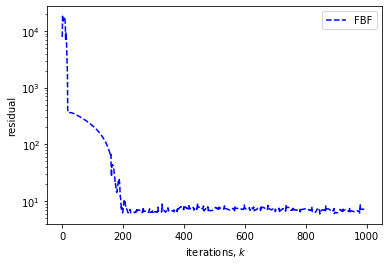

Answer is 7.215473117187611
Answer is [5.38402313e-120 1.80773239e-141 1.67837866e-001 5.40092447e-001
 9.79751417e-001 1.23116153e-023 2.04236909e+000 5.15381400e-143
 1.92219761e-112 1.38154025e+000 1.28441943e-002 1.28441943e-002
 1.28441943e-002 1.28441943e-002 1.28441943e-002 1.28441943e-002
 1.28441943e-002 1.28441943e-002 1.28441943e-002 1.28441943e-002
 1.07916987e+000 3.38981038e-001 1.28570063e+000 1.11558546e+000
 1.18584032e+000 1.10455141e+000 1.69354435e+000 1.35356484e+000
 1.85694576e+000 1.84315033e+000]
Answer is 26.6714200744562


In [7]:
plt.plot(ans1[0], '--b', label = 'FBF')

plt.yscale('log')

plt.xlabel(u' iterations, $k$')
plt.ylabel(u'residual')

plt.legend()
#plt.savefig('figures/nash.pdf', bbox_inches='tight')
plt.show()
print("Answer is", ans1[0][-1])
print("Answer is", ans1[2])
print("Answer is", fx(ans1[2][0:dimX]))

## Solving the QCQP

In [8]:
from scipy.optimize import minimize
cons = []
for i in range(len(hx)):
    temp = ({'type': 'ineq', 'fun': lambda x: hx[i](x) })
    cons.append(temp)
bnds = []
for i in range(dimX):
    temp = ((0, None))
    bnds.append(temp)
x = np.ones(dimX)
res = minimize(fx, x, method='SLSQP', bounds=bnds, constraints=cons)

In [9]:
print(fx(res['x']))
print(res['x'])
#print("Answer is:", res)

19.716368384293858
[0.00000000e+00 1.15809263e-13 1.25250057e+00 0.00000000e+00
 0.00000000e+00 0.00000000e+00 3.73778765e-12 1.93020148e-13
 2.85083031e+00 0.00000000e+00]
